<a href="https://colab.research.google.com/github/shreyaadarakh/DL/blob/master/CvM2_J009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

In [0]:
ref = cv2.imread("reference.png")
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]

In [0]:
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
refCnts = imutils.grab_contours(refCnts)
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
digits = {}

In [0]:
for (i, c) in enumerate(refCnts):
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
    digits[i] = roi

In [0]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

In [0]:
image = cv2.imread("CreditCard.png")
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [0]:
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)

In [0]:
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

In [0]:
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)

In [0]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []

In [0]:
for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if ar > 2.5 and ar < 4.0:
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            locs.append((x, y, w, h))

In [0]:
locs = sorted(locs, key=lambda x:x[0])
output = []

In [0]:
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    groupOutput = []
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = digitCnts[0]
    digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]

    for c in digitCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
        scores = []

        for (digit, digitROI) in digits.items():
            result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)

        groupOutput.append(str(np.argmax(scores)))

    cv2.rectangle(image, (gX - 5, gY - 5), (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
    cv2.putText(image, "".join(groupOutput), (gX, gY - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

    output.extend(groupOutput)

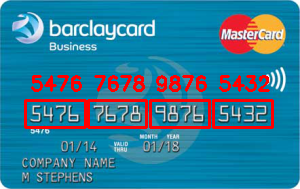

In [59]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)